# The KLT Tracker
*By Erik Gärtner*


### 1.2.2 Inverse-additive scheme

The inverse-additive shceme is the following:
\begin{align}
E(u, v) = \sum_{x,y} [J(x, y) - I(x - u, y -v)] ^2
\end{align}

Which is derived into the form of $Zd = e$:

\begin{align}
\sum_{x,y} 
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2 \\
\end{bmatrix} 
\begin{bmatrix}
u \\
v
\end{bmatrix} = - \sum_{x,y}
\begin{bmatrix}
I_x D \\
I_y D
\end{bmatrix}
\end{align}

where D is $D(x,y) = J(x,y) - I(x,y)$

### Helper functions

In [141]:
import numpy as np
from  scipy import ndimage, interpolate

from matplotlib.pyplot import imshow, imread
import matplotlib.pyplot as plt
from PIL import Image

In [142]:
def load_img(path='./view0.png', gray=True):
    rgb = Image.open(path)
    rgb = np.array(rgb)
    if gray:
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    else:
        return rgb
    
I = load_img()
J = load_img('./view1.png')

### 1.3.1 Gradient Function

In [143]:
X_FILTER = np.array([[3.0, 0.0, -3.0], [10.0, 0.0, 10.0], [3.0, 0.0, -3.0]])
Y_FILTER = X_FILTER.T

def differentiate(img_arr):
    x_diff = ndimage.convolve(img_arr, X_FILTER, mode='constant', cval=0.0)
    y_diff = ndimage.convolve(img_arr, Y_FILTER, mode='constant', cval=0.0)
    return (x_diff, y_diff)

### 1.3.2 Estimating Z

In [144]:
def estimate_Z(x_diff, y_diff):
    Ix = x_diff
    Iy = y_diff
    
    Ixx = np.multiply(Ix, Ix)
    Ixy = np.multiply(Ix, Iy)
    Iyy = np.multiply(Iy, Iy)
    
    Sxx = np.sum(Ixx)
    Sxy = np.sum(Ixy)
    Syy = np.sum(Iyy)
        
    Z = np.array([
        [Sxx, Sxy],
        [Sxy, Syy]
    ])
    return Z 

### 1.3.3 Difference Function

In [145]:
def estimate_e(I, J, x_diff, y_diff):
    Ix = x_diff
    Iy = y_diff
    
    D = I - J
    
    Sx = -1 * np.sum(np.multiply(Ix, D))
    Sy = -1 * np.sum(np.multiply(Iy, D))
    
    return np.array([Sx, Sy]).T

### 1.3.4 Interpolation Function

In [146]:
def interpolate_region(img_array):
    """
    Creates an bilinear interpolation of the image area sent in.
    Evaluate using spline(x, y)
    """
    x_arr = np.arange(0, img_array.shape[0])
    y_arr = np.arange(0, img_array.shape[1])
    spline = interpolate.RectBivariateSpline(x_arr, y_arr, img_array, kx=1, ky=1)
    return spline

### 1.3.5 Finalizing the KLT Tracker

Some notes, 
- I had to use the pseudo-inverse because I got a singular matrix Z.
- Should I interpolate the images as I have done, that is first compute the gradients of the entire image, then create interpolation of the entire image and image gradients.

In [154]:
def calc_klt(old_image, new_image, input_points, win_size=(21, 21), max_iter=30, min_disp=0.01):
    
    output_points = []
    for (x, y) in input_points:
        d = calc_d(old_image, new_image, x, y, win_size, max_iter, min_disp)
        output_points.append((x + d[0], y + d[1]))
    return output_points


def calc_d(I, J, x, y, win_size, max_iter, min_disp):
    
    it = 0
    d_tot = 0
    
    # The window to evaluate
    win_x = np.arange(x, x + win_size[0], dtype=float)
    win_y = np.arange(y, y + win_size[1], dtype=float)
    
    # Find image gradient in I
    Ix, Iy = differentiate(I)
    
    # Create interpolated versions of gradient and images
    I_inter = interpolate_region(I)
    J_inter = interpolate_region(J)
    Ix_inter = interpolate_region(Ix)
    Iy_inter = interpolate_region(Iy)    
    
    while it < max_iter:
        
        # Get the current window
        Ix_win = Ix_inter(win_x, win_y)
        Iy_win = Iy_inter(win_x, win_y)
        I_win = I_inter(win_x, win_y)
        J_win = J_inter(win_x, win_y)
        
        Z = estimate_Z(Ix_win, Ix_win)
        e = estimate_e(I_win, J_win, Ix_win, Ix_win)
        
        Zinv = np.linalg.inv(Z)
        d = np.dot(Zinv, e)
        
        d_tot = d_tot + d
        
        if np.hypot(d[0], d[1]) <= min_disp:
            # Check if converged
            return d_tot
        
        # Shift I and J by d
        win_x += d[0]
        win_y += d[1]
        
        it += 1
    
    return d_tot   

### 1.3.6 Test Implementation

In [153]:
import cv2

def opencv_klt(old_image, new_image, input_points, win_size=(21, 21)):
    pts = np.array(input_points ,np.float32)
    I2 = I.astype(np.uint8)
    J2 = J.astype(np.uint8)
    res = cv2.calcOpticalFlowPyrLK(I2, J2, pts, None, winSize=win_size, maxLevel=0) #prevPts[, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]])
    return res[0]

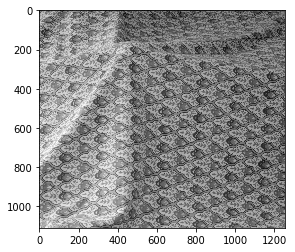

In [148]:
#imshow(I, cmap = plt.get_cmap('gray'))

In [155]:
calc_d(I, J, 320, 336, (21, 21), 30, 0.001)

LinAlgError: Singular matrix